In [108]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator
from torchtext.data.metrics import bleu_score

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

from tqdm import tqdm

from model.Encoder import Encoder
from model.Decoder import Decoder
from model.Generator import Generator
from model.Transformer import Transformer

from typing import List, Tuple, Union
import matplotlib.pyplot as plt

In [109]:
SEED = 25

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [110]:
spacy_fr = spacy.load('fr_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

def tokenize_en(text: str) -> List[str]:
    """
    Translates English text sequence into a list of tokens.

    Args:
        text (str): The English text sequence to be tokenized.

    Returns:
        List[str]: A list of tokens representing the English text.
    """
    return [token.text for token in spacy_en.tokenizer(text)]

def tokenize_fr(text: str) -> List[str]:
    """
    Translates French text sequence into a list of tokens.

    Args:
        text (str): The French text sequence to be tokenized.

    Returns:
        List[str]: A list of tokens representing the French text.
    """
    return [token.text for token in spacy_fr.tokenizer(text)]

PAD_TOKEN = '<pad>'  #  represents the padding token used to fill sequences of different lengths to make them equal in length during batching or processing.
SOS_TOKEN = '<s>'  # represents the start-of-sentence token, indicating the beginning of a sentence.
EOS_TOKEN = '</s>'  # represents the end-of-sentence token, indicating the end of a sentence.
UNK_TOKEN = '<unk>'  # represents the unknown token, used to represent words or tokens that are out-of-vocabulary or unknown.

# english text field
en_text = Field(
    tokenize=tokenize_en, lower=True, include_lengths=True, batch_first=True,
    pad_token=PAD_TOKEN, init_token=SOS_TOKEN, eos_token=EOS_TOKEN, unk_token=UNK_TOKEN,
)

# french text field
fr_text = Field(
    tokenize=tokenize_fr, lower=True, include_lengths=True, batch_first=True,
    pad_token=PAD_TOKEN, init_token=SOS_TOKEN, eos_token=EOS_TOKEN, unk_token=UNK_TOKEN,
)

c:\Users\victo\AppData\Local\Programs\Python\Python310\lib\site-packages\spacy\util.py:877: UserWarning: [W095] Model 'fr_core_news_sm' (3.5.0) was trained with spaCy v3.5 and may not be 100% compatible with the current version (3.4.4). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
c:\Users\victo\AppData\Local\Programs\Python\Python310\lib\site-packages\spacy\util.py:877: UserWarning: [W095] Model 'en_core_web_sm' (3.5.0) was trained with spaCy v3.5 and may not be 100% compatible with the current version (3.4.4). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [111]:
data_fields = (('src', en_text), ('trg', fr_text))

train_data, valid_data, test_data = Multi30k.splits(exts=('.en', '.fr'), fields=data_fields)
#  the source language (English) and target language (french) respectively.

In [112]:
# build the english and french vocabulary
en_text.build_vocab(train_data.src, max_size=10000, min_freq=2)
fr_text.build_vocab(train_data.trg, max_size=10000, min_freq=2)

In [113]:
PAD_IDX = fr_text.vocab.stoi[PAD_TOKEN]
SOS_IDX = fr_text.vocab.stoi[SOS_TOKEN]
EOS_IDX = fr_text.vocab.stoi[EOS_TOKEN]
UNK_IDX = fr_text.vocab.stoi[UNK_TOKEN]

"""
These variables can be useful when working with the french vocabulary to access specific token indices.
For example, you can use PAD_IDX to identify the index of the padding token when processing french sequences,
or use SOS_IDX and EOS_IDX to mark the start and end of sequences during inference or evaluation.
Similarly, UNK_IDX can be used to handle out-of-vocabulary or unknown tokens in the french text.  
"""

print(f'English vocabulary: {len(en_text.vocab)} words')
print(f'french vocabulary: {len(fr_text.vocab)} words')

English vocabulary: 5893 words
french vocabulary: 6470 words


In [114]:
print(f'# of training examples: {len(train_data.examples)}')
print(f'# of validation examples: {len(valid_data.examples)}')
print(f'# of testing examples: {len(test_data.examples)}')

print(train_data[0].__dict__.keys())
print(train_data[0].__dict__.values())

# of training examples: 29000
# of validation examples: 1014
# of testing examples: 1000
dict_keys(['src', 'trg'])
dict_values([['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.'], ['deux', 'jeunes', 'hommes', 'blancs', 'sont', 'dehors', 'près', 'de', 'buissons', '.']])


In [115]:
BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=BATCH_SIZE,
    sort_within_batch=True,
    sort_key=lambda x: len(x.src),
)

In [116]:
# sanity check to see if data loader is working
x = next(iter(train_iterator))

print({'source': x.src[0].shape, 'source_lengths': x.src[1].shape})
print({'target': x.trg[0].shape, 'target_lengths': x.trg[1].shape})

{'source': torch.Size([64, 11]), 'source_lengths': torch.Size([64])}
{'target': torch.Size([64, 16]), 'target_lengths': torch.Size([64])}


In [117]:
def model_summary(model:nn.Module):
    """
    Prints a summary of the model, including the number of trainable and non-trainable parameters.

    Args:
        model (Transformer): The transformer model.
    """
    print(model)
    print(f'# of trainable params: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')
    print(f'# of non-trainable params: {sum(p.numel() for p in model.parameters() if not p.requires_grad):,}')

In [118]:
def convert_ids_to_text(ids: torch.Tensor, vocab: torchtext.vocab.Vocab, eos_idx: int, unk_idx: int) -> Union[List[str], List[List[str]]]:

    """
    Converts token ids to text.

    Args:
        ids (torch.Tensor): The token ids to be converted.
        vocab (torchtext.vocab.Vocab): The vocabulary object.
        eos_idx (int): The index representing the end-of-sentence token.
        unk_idx (int): The index representing the unknown token.

    Returns:
        Union[List[str], List[List[str]]]: The converted tokens as a list of strings
        or a list of lists of strings, depending on the input dimensions.
    """
    if ids.dim() == 1:
        output_tokens = []
        for token_id in ids:
            if token_id == eos_idx:
                break
            else:
                output_tokens.append(vocab.itos[token_id])
        return output_tokens
    
    elif ids.dim() == 2:
        return [convert_ids_to_text(ids[i, :], vocab, eos_idx, unk_idx) for i in range(ids.size(0))]
    
    raise RuntimeError(f'ids has {ids.size()} dimensions, expected 2 dimensions')

In [119]:
class NoamOptim(object):
    """
    Optimizer wrapper for learning rate scheduling.

    Args:
        optimizer (torch.optim.Optimizer): The base optimizer.
        d_model (int): The model's hidden size.
        factor (int): The factor used to compute the learning rate.
        n_warmup_steps (int): The number of warm-up steps for the learning rate.

    Methods:
        zero_grad(): Clears the gradients of all optimized parameters.
        step(): Updates the parameters and performs optimization.
        get_lr(): Computes the learning rate at the current step.
    """

    def __init__(self, optimizer: optim.Adam, d_model: int, factor: int, n_warmup_steps: int):
        self.optimizer = optimizer
        self.d_model = d_model
        self.factor = factor
        self.n_warmup_steps = n_warmup_steps
        self.n_steps = 0
    

    def zero_grad(self):
        self.optimizer.zero_grad()


    def step(self):
        self.n_steps += 1
        lr = self.get_lr()
        for p in self.optimizer.param_groups:
            p['lr'] = lr
        self.optimizer.step()

    
    def get_lr(self):
        return self.factor * (
            self.d_model ** (-0.5)
            * min(self.n_steps ** (-0.5), self.n_steps * self.n_warmup_steps ** (-1.5))
        )

In [120]:
def train_fn(model: nn.Module, iterator: BucketIterator, optimizer: NoamOptim, criterion: nn.CrossEntropyLoss, clip: float = 1.0) -> Tuple[torch.Tensor, float]:

    """
    Trains the model for one epoch.

    Args:
        model (Transformer): The transformer model to be trained.
        iterator (torchtext.data.Iterator): The iterator for training data.
        optimizer (NoamOptim): The optimizer for parameter updates.
        criterion (torch.nn.modules.loss._Loss): The loss criterion.
        clip (float): The value used to clip the gradients to avoid exploding gradients.

    Returns:
        Tuple[torch.Tensor, float]: The output predictions and perplexity.
    """
    model.train()
    total_loss = 0
    steps = 0

    tk0 = tqdm(iterator, total=len(iterator), position=0, leave=True)

    for idx, batch in enumerate(tk0):
        source, source_lengths = batch.src
        target, target_lengths = batch.trg

        # source: (batch_size, source_seq_len), source_lengths: (batch_size)
        # target: (batch_size, target_seq_len), target_lengths: (batch_size)
        
        # forward pass
        optimizer.zero_grad()
        output, _ = model(source, target[:, :-1])  # (batch_size, target_seq_len - 1, vocab_size)
        
        # calculate the loss
        loss = criterion(
            output.view(-1, output.size(-1)),  # (batch_size * (target_seq_len - 1), vocab_size)
            target[:, 1:].contiguous().view(-1)  # (batch_size * (target_seq_len - 1))
        )
        total_loss += loss.item()
        steps += 1

        output = output.argmax(dim=-1)  # (batch_size, target_seq_len - 1)

        # backward pass
        loss.backward()

        # clip gradients to avoid exploding gradients issue
        nn.utils.clip_grad_norm_(model.parameters(), clip)

        # update model parameters
        optimizer.step()
        
        tk0.set_postfix(loss=total_loss/steps)

    tk0.close()

    perplexity = np.exp(total_loss / len(iterator))
    
    return output, perplexity

In [121]:
def eval_fn(model: nn.Module, iterator: BucketIterator, criterion: nn.CrossEntropyLoss, optimizer: NoamOptim) -> Tuple[torch.Tensor, float, float]:

    """
    Evaluates the model on the validation or test data.

    Args:
        model (Transformer): The transformer model to be evaluated.
        iterator (torchtext.data.Iterator): The iterator for validation or test data.
        criterion (torch.nn.modules.loss._Loss): The loss criterion.
        optimizer (NoamOptim): The optimizer (not used in evaluation).

    Returns:
        Tuple[torch.Tensor, float, float]: The output predictions, perplexity, and BLEU-4 score.
    """
    model.eval()
    total_loss = 0.0
    steps = 0
    hypotheses = []
    references = []

    tk0 = tqdm(iterator, total=len(iterator), position=0, leave=True)

    with torch.no_grad():
        for idx, batch in enumerate(tk0):
            source, source_lengths = batch.src
            target, target_lengths = batch.trg

            # source: (batch_size, source_seq_len), source_lengths: (batch_size)
            # target: (batch_size, target_seq_len), target_lengths: (batch_size)
            
            # forward pass
            optimizer.zero_grad()
            output, _ = model(source, target[:, :-1])  # (batch_size, target_seq_len - 1, vocab_size)
            
            # calculate the loss
            loss = criterion(
                output.view(-1, output.size(-1)),  # (batch_size * (target_seq_len - 1), vocab_size)
                target[:, 1:].contiguous().view(-1)  # (batch_size * (target_seq_len - 1))
            )
            total_loss += loss.item()
            steps += 1

            output = output.argmax(dim=-1)  # (batch_size, target_seq_len - 1)
            target = target[:, 1:]  # (batch_size, target_seq_len - 1)

            # converting the ids to tokens (used later for calculating BLEU score)
            pred_tokens = convert_ids_to_text(output, fr_text.vocab, EOS_IDX, UNK_IDX)
            target_tokens = convert_ids_to_text(target, fr_text.vocab, EOS_IDX, UNK_IDX)

            hypotheses += pred_tokens
            references += [[token] for token in target_tokens]

            tk0.set_postfix(loss=total_loss/steps)

    tk0.close()

    perplexity = np.exp(total_loss / len(iterator))
    bleu4 = bleu_score(hypotheses, references)
    
    return output, perplexity, bleu4

In [122]:
# hyperparameters
INPUT_SIZE = len(en_text.vocab)  # source vocab size
OUTPUT_SIZE = len(fr_text.vocab)  # target vocab size
HIDDEN_SIZE = 512
N_LAYERS = 6
N_HEADS = 8
FF_SIZE = 2048
DROPOUT_RATE = 0.1
N_EPOCHS = 1
CLIP = 1.0

In [123]:
encoder = Encoder(INPUT_SIZE, HIDDEN_SIZE, N_LAYERS, N_HEADS, FF_SIZE, PAD_IDX, DROPOUT_RATE)
decoder = Decoder(OUTPUT_SIZE, HIDDEN_SIZE, N_LAYERS, N_HEADS, FF_SIZE, PAD_IDX, DROPOUT_RATE)
generator = Generator(HIDDEN_SIZE, OUTPUT_SIZE)

model = Transformer(encoder, decoder, generator, PAD_IDX)
model_summary(model)

Transformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(5893, 512, padding_idx=1)
    (pos_embedding): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (layers): ModuleList(
      (0-5): 6 x EncoderLayer(
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=512, out_features=512, bias=True)
          (fc_k): Linear(in_features=512, out_features=512, bias=True)
          (fc_v): Linear(in_features=512, out_features=512, bias=True)
          (fc_o): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (self_attention_layer_norm): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
        (positionwise_feedforward): PositionWiseFeedForwardLayer(
          (fc_1): Linear(in_features=512, out_features=2048, bias=True)
          (fc_2): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )

In [124]:
optimizer = NoamOptim(
    optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.98), eps=1e-9),
    HIDDEN_SIZE, 2, 4000
)

In [125]:
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [ ]:
best_bleu4 = float('-inf')
es_patience = 3
patience = 0
model_path = 'model.pth'


for epoch in range(0, N_EPOCHS):
    # one epoch training
    _, train_perplexity = train_fn(model, train_iterator, optimizer, criterion, CLIP)
    
    # one epoch validation
    _, valid_perplexity, valid_bleu4 = eval_fn(model, valid_iterator, criterion, optimizer)
    
    print(f'Epoch: {epoch}, Train perplexity: {train_perplexity:.4f}, Valid perplexity: {valid_perplexity:.4f}, Valid BLEU4: {valid_bleu4:.4f}')
    
    # early stopping
    is_best = valid_bleu4 > best_bleu4
    if is_best:
        print(f'BLEU score improved ({best_bleu4:.4f} -> {valid_bleu4:.4f}). Saving Model!')
        best_bleu4 = valid_bleu4
        patience = 0
        torch.save(model.state_dict(), model_path)
    else:
        patience += 1
        print(f'Early stopping counter: {patience} out of {es_patience}')
        if patience == es_patience:
            print(f'Early stopping! Best BLEU4: {best_bleu4:.4f}')
            break

In [ ]:
# evaluate the model on test data
model.load_state_dict(torch.load(model_path))

print('Evaluating the model on test data ...')
_, test_perplexity, test_bleu4 = eval_fn(model, test_iterator, criterion, optimizer)
print(f'Test perplexity: {test_perplexity:.4f}, Test BlEU4: {test_bleu4:.4f}')

Evaluating the model on test data ...


100%|██████████| 16/16 [00:36<00:00,  2.27s/it, loss=3.29]


Test perplexity: 26.8506, Test BlEU4: 0.1143


In [ ]:
def greedy_decode(model: Transformer, sentence: Union[str, List[str]], max_len: int = 100) -> Tuple[List[str], np.ndarray]:
    """
    Performs greedy decoding to generate the translation of a given sentence.

    Args:
        model (Transformer): The transformer model.
        sentence (str): The input sentence to be translated.
        max_len (int): The maximum length of the generated translation.

    Returns:
        str: The generated translation.
    """
    model.eval()

    if isinstance(sentence, str):
        tokens = [token.text.lower() for token in spacy_fr(sentence)]
    else:
        tokens = [token.lower() for token in sentence]
    
    token_ids = [SOS_IDX] + [en_text.vocab.stoi.get(token, UNK_TOKEN) for token in tokens] + [EOS_IDX]
    
    source = torch.tensor(token_ids, dtype=torch.long).unsqueeze(0)  # (1, source_seq_len)
    source_mask = model.get_pad_mask(source, PAD_IDX)  # (1, 1, source_seq_len)

    # encode the source sequence
    with torch.no_grad():
        enc_output = model.encoder(source, source_mask)  # (1, source_seq_len, d_model)
    
    target_ids = [SOS_IDX]

    for i in range(max_len):
        target = torch.tensor(target_ids, dtype=torch.long).unsqueeze(0)  # (1, target_seq_len)
        target_mask = model.get_pad_mask(target, PAD_IDX) & model.get_subsequent_mask(target)

        # decode the sequence
        with torch.no_grad():
            dec_output, attn = model.decoder(target, enc_output, source_mask, target_mask)

            # dec_output: (1, target_seq_len, d_model)
            # attn: (1, n_heads, target_seq_len, source_seq_len)

            output = model.generator(dec_output)  # (1, target_seq_len, vocab_size)

        target_id = output.argmax(dim=-1)[:, -1].item()
        target_ids.append(target_id)

        # stop decoding if we encounter EOS_TOKEN or reach the max length
        if target_id == EOS_IDX or len(target_ids) >= max_len:
            break
        
    target_tokens = [fr_text.vocab.itos[id] for id in target_ids]
    attn = attn.squeeze(0).cpu().detach().numpy()  # (n_heads, target_seq_len, source_seq_len)

    # target_tokens: list of size (target_seq_len - 1)
    # attn: (n_heads, target_seq_len, source_seq_len)
    
    return target_tokens[1:], attn

In [ ]:
def plot_attention_scores(source: Union[str, List[str]], target: List[str], attention: np.ndarray) -> None:
    """
    Plots the attention scores between the source and target tokens.

    Args:
        src_tokens (List[str]): The list of source tokens.
        trg_tokens (List[str]): The list of target tokens.
        attention_scores (torch.Tensor): The attention scores between the source and target tokens.
            Shape: (target_length, source_length).

    Returns:
        None
    """
    n_heads = attention.shape[0]

    if isinstance(source, str):
        source = [token.lower for token in source.split(" ")] + [EOS_TOKEN]
    else:
        source = [token.lower() for token in source] + [EOS_TOKEN]

    fig = plt.figure(figsize=(24, 12))

    for h, head in enumerate(attention):
        ax = fig.add_subplot(2, 4, h + 1)
        x = source
        y = target if h % 4 == 0 else []

        sns.heatmap(
            head, xticklabels=x, yticklabels=y, square=True,
            vmin=0.0, vmax=1.0, cbar=False, cmap="Blues", ax=ax,
        )

source: ['a', 'man', 'is', 'smiling', 'at', 'a', 'stuffed', 'lion']

target: ['ein', 'mann', 'lächelt', 'einen', 'ausgestopften', 'löwen', 'an', '.']

predicted: ['ein', 'mann', 'lächelt', 'an', 'einem', '<unk>', '.', '</s>']



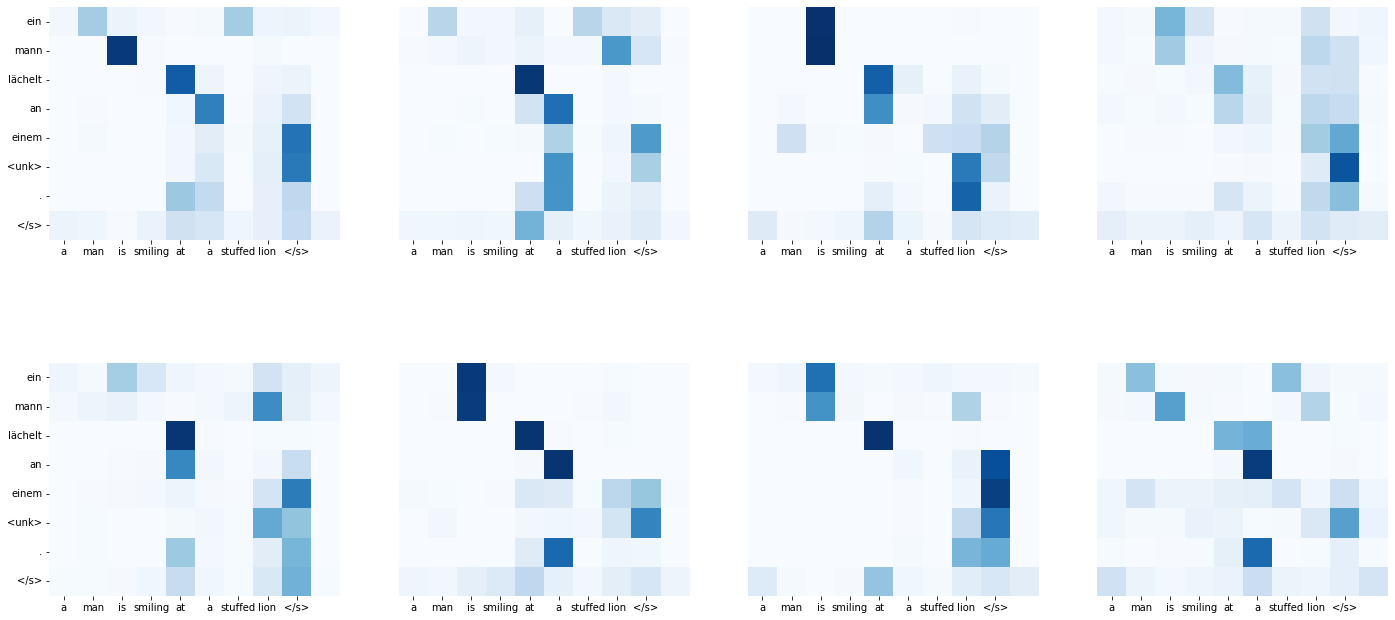

In [ ]:
example_idx = 6

source = vars(train_data.examples[example_idx])['src']
target = vars(train_data.examples[example_idx])['trg']

predicted, attention_scores = greedy_decode(model, source)

print(f'source: {source}\n')
print(f'target: {target}\n')
print(f'predicted: {predicted}\n')

plot_attention_scores(source, predicted, attention_scores)